# Data pre-processing

## Imports

In [366]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from functions import sig, alter_sig, sigfit, alter_sigfit
pd.options.mode.chained_assignment = None # Stop seeing warnings

## Load data

### Load Demographic data

In [367]:
sheet_url = "https://docs.google.com/spreadsheets/d/1H9DApYyqdZ0iVAvFKBodHrH654K0NwKzldf5xz5m2tc/edit#gid=1885121359"
url_demographic = sheet_url.replace("/edit#gid=", "/export?format=csv&gid=")
data_demographic = pd.read_csv(url_demographic)
data_demographic.head(5)

,Marca temporal,Código de participante,He sido informado sobre la naturaleza del estudio y doy mi consentimiento para participar:,Sexo,Edad (en años),Nivel educativo,Ocupación,¿Eres beneficiario de alguna beca académica? ¿Cuál?,"¿Has sido diagnosticada/o con alguna de las siguientes condiciones? (De ser así, por favor marca las opciones correspondientes).",¿Presentas problemas de visión sin corregir?,...,"2. Por lo general me concentro más en ""la imagen completa"", en lugar de en los pequeños detalles.",3. Me resulta fácil hacer más de una cosa a la vez.,"4. Si hay una interrupción, puedo volver a concentrarme en lo que estaba haciendo muy rápido.","5. Me resulta fácil ""leer entre líneas"" cuando alguien me está hablando.",6. Sé cómo saber si alguien que me escucha se está aburriendo.,"7. Cuando estoy leyendo una historia, me resulta difícil descifrar las intenciones de los personajes.","8. Me gusta recabar información sobre categorías de cosas (por ejemplo: tipos de automóviles, tipos de aves, tipos de trenes, tipos de plantas, etc.)",9. Me resulta fácil saber lo que alguien está pensando o sintiendo simplemente mirando su rostro.,10. Me resulta difícil comprender las intenciones de las personas.,"¿Tienes historial de trastornos neurológicos? (Ejem. afasia, dislexia, etc.)"
0,30/1/2024 10:34:23,P01,NaN,Femenino,23,Universitario incompleto,Universitaria,NaN,No,No,...,4.0,3.0,3.0,3.0,3.0,1.0,1.0,3.0,3.0,No
1,30/1/2024 12:30:34,P02,NaN,Femenino,21,Universitario incompleto,estudiante,NaN,Trastorno de Déficit de Atención,No,...,1.0,4.0,3.0,1.0,2.0,1.0,4.0,4.0,4.0,Si
2,30/1/2024 14:13:03,P03,NaN,Masculino,21,Universitario incompleto,Estudiante,NaN,No,Si,...,2.0,4.0,2.0,2.0,4.0,3.0,4.0,3.0,3.0,No
3,30/1/2024 15:33:06,P04,NaN,Masculino,21,Universitario incompleto,Estudiante,NaN,Trastorno del Espectro Autista,No,...,1.0,1.0,2.0,2.0,3.0,1.0,4.0,2.0,4.0,No
4,13/3/2024 16:33:02,A01,NaN,SEMIHOMBRE,21,Universitario incompleto,ESTUDIANTE,NaN,No,Si,...,3.0,3.0,3.0,3.0,4.0,2.0,2.0,3.0,2.0,No


### Load DFI data

In [368]:
# Get participant files name
participant_files = []
for p in Path("./data_ac").glob("*.csv"):
    participant_files.append(f"{p.name}")

# Create empty DataFrame
data_dfi = pd.DataFrame()

# Compute data for each participant
for participant_file in participant_files:
    data = pd.read_csv("data_ac/" + participant_file)
    data = data[
        [
            "participant",
            "SOA",
            "confidence_slider.response",
            "confidence_slider.rt",
            "key_resp.keys",
            "key_resp.rt",
        ]
    ]
    data = data.dropna()

    par_df = pd.DataFrame()

    for soa in data.SOA.unique():
        soa_df = data.query("SOA == @soa")
        confidence = soa_df["confidence_slider.response"].mean()

        confidence_rt = soa_df["confidence_slider.rt"].mean()
        two_flashes = soa_df[soa_df["key_resp.keys"] == "num_2"].shape[0]
        two_flashes_rt = soa_df["key_resp.rt"].mean()

        par = {
            "Participant": data.participant.iloc[-1],
            "SOA": soa,
            "Confidence": confidence,
            "Illusion_count": two_flashes,
            "Confidence_RT": confidence_rt,
            "Illusion_count_RT": two_flashes_rt,
        }

        new_df = pd.DataFrame(data=par, index=[soa])
        par_df = pd.concat([par_df, new_df], ignore_index=True)

    # Append to final Dataframe
    data_dfi = pd.concat([data_dfi, par_df], ignore_index=True)

data_dfi["SOA"].unique()

array([14., 13., 11.,  6., 12.,  9.,  8.,  4.,  2., 16.,  7.,  3.,  5.,
       10., 15.])

### Load Audiometry data

In [369]:
sheet_url = "https://docs.google.com/spreadsheets/d/1fNNucIiKoI6WyVRBQCq-m2NgCjLb-PdJ_W8OI22_Znc/edit#gid=0"
url_pure_tone = sheet_url.replace("/edit#gid=", "/export?format=csv&gid=")
data_pure_tone = pd.read_csv(url_pure_tone)
data_pure_tone

,Participant ID,Ear,Frequency (Hz),Hearing Level (dB),Date,Evaluator
0,AC01,R,1000,20,21/03,Fernando
1,AC01,R,2000,10,21/03,Fernando
2,AC01,R,4000,15,21/03,Fernando
3,AC01,R,8000,5,21/03,Fernando
4,AC01,R,500,20,21/03,Fernando
...,...,...,...,...,...,...
415,AC36,L,2000,0,16/04,Fernando
416,AC36,L,4000,5,16/04,Fernando
417,AC36,L,8000,5,16/04,Fernando
418,AC36,L,500,15,16/04,Fernando


In [370]:
sheet_url = "https://docs.google.com/spreadsheets/d/1fNNucIiKoI6WyVRBQCq-m2NgCjLb-PdJ_W8OI22_Znc/edit#gid=309462883"
url_ldl = sheet_url.replace("/edit#gid=", "/export?format=csv&gid=")
data_ldl = pd.read_csv(url_ldl)

## Scales scoring preprocessing

### Autism Questionnaire calculation

In [371]:
# Revise columns
data_demographic.columns

Index(['Marca temporal', 'Código de participante',
       'He sido informado sobre la naturaleza del estudio y doy mi consentimiento para participar:',
       'Sexo', 'Edad (en años)', 'Nivel educativo', 'Ocupación',
       '¿Eres beneficiario de alguna beca académica? ¿Cuál?',
       '¿Has sido diagnosticada/o con alguna de las siguientes condiciones? (De ser así, por favor marca las opciones correspondientes).',
       '¿Presentas problemas de visión sin corregir?',
       '¿Presentas problemas de audición sin corregir?',
       '¿Tienes algún diagnóstico psiquiátrico?',
       'En caso hayas recibido un diagnostico psiquiátrico, ¿cuál fue?',
       '¿Consumes alguna medicación psiquiátrica?',
       '¿Cuántas horas dormiste anoche?',
       '¿Cuántas horas en promedio has dormido en las últimas dos semanas?',
       '1. Muchas veces noto pequeños sonidos en los que otros no reparan.',
       '2. Por lo general me concentro más en "la imagen completa", en lugar de en los pequeños det

In [372]:
# Only keep columns corresponding to the scale 
autism_scale_cols = ['Código de participante','1. Muchas veces noto pequeños sonidos en los que otros no reparan.',
       '2. Por lo general me concentro más en "la imagen completa", en lugar de en los pequeños detalles.',
       '3. Me resulta fácil hacer más de una cosa a la vez.',
       '4. Si hay una interrupción, puedo volver a concentrarme en lo que estaba haciendo muy rápido.',
       '5. Me resulta fácil "leer entre líneas" cuando alguien me está hablando.',
       '6. Sé cómo saber si alguien que me escucha se está aburriendo.',
       '7. Cuando estoy leyendo una historia, me resulta difícil descifrar las intenciones de los personajes.',
       '8. Me gusta recabar información sobre categorías de cosas (por ejemplo: tipos de automóviles, tipos de aves, tipos de trenes, tipos de plantas, etc.)',
       '9. Me resulta fácil saber lo que alguien está pensando o sintiendo simplemente mirando su rostro.',
       '10. Me resulta difícil comprender las intenciones de las personas.']
data_demographic_autism = data_demographic[autism_scale_cols]

# Rename columns so it's easier to handle
data_demographic_autism.columns = ['Código de participante','AQ_1','AQ_2','AQ_3','AQ_4',
                                                      'AQ_5','AQ_6','AQ_7','AQ_8','AQ_9','AQ_10']

How to manage scoring (Beatriz, 2020):

Each item can have a score of 0 or 1:  
1) Score 1 if the person selected 3 and 4 in items 1,7,8 and 10
2) Score 0 if the person has selected the options 1 and 2 in items 2,3,4,5,6 and 9
Subsequently, sum all obtained punctuations.

3) If the total score is within 6 and 10, consider refering to a specialized diagnosis and intervention center (cutting point for "meeting criteria")


In [373]:
data_demographic_autism.dropna(inplace=True) # Remove participants with NaN values in this scale, as having any NaN values would mess up the scoring

In [374]:
# Step 1)
data_demographic_autism['AQ_1'] = np.where(data_demographic_autism['AQ_1'].isin([3.0, 4.0]), 1,0)
data_demographic_autism['AQ_7'] = np.where(data_demographic_autism['AQ_7'].isin([3.0, 4.0]), 1,0)
data_demographic_autism['AQ_8'] = np.where(data_demographic_autism['AQ_8'].isin([3.0, 4.0]), 1,0)
data_demographic_autism['AQ_10'] = np.where(data_demographic_autism['AQ_10'].isin([3.0, 4.0]), 1,0)

# Step 2)
data_demographic_autism['AQ_2'] = np.where(data_demographic_autism['AQ_2'].isin([1.0, 2.0]), 0,1)
data_demographic_autism['AQ_3'] = np.where(data_demographic_autism['AQ_3'].isin([1.0, 2.0]), 0,1)
data_demographic_autism['AQ_4'] = np.where(data_demographic_autism['AQ_4'].isin([1.0, 2.0]), 0,1)
data_demographic_autism['AQ_5'] = np.where(data_demographic_autism['AQ_5'].isin([1.0, 2.0]), 0,1)
data_demographic_autism['AQ_6'] = np.where(data_demographic_autism['AQ_6'].isin([1.0, 2.0]), 0,1)
data_demographic_autism['AQ_9'] = np.where(data_demographic_autism['AQ_9'].isin([1.0, 2.0]), 0,1)


In [375]:
# Sum all values
data_demographic_autism["AQ_TOTAL"] = data_demographic_autism.iloc[:,:-1].sum(axis=1, numeric_only=True)

In [376]:
# Step 3)
data_demographic_autism['AQ_MC'] = np.where(data_demographic_autism['AQ_TOTAL'].ge(6),1, 0) #Autism Questionnaire Meets Criteria -> 0: No, 1: Yes


df_aq = data_demographic_autism[["Código de participante", "AQ_TOTAL", "AQ_MC"]]
df_aq.head()

,Código de participante,AQ_TOTAL,AQ_MC
0,P01,6,1
1,P02,4,0
2,P03,6,1
3,P04,3,0
4,A01,6,1


## DFI experiment preprocessing

### Obtain OPI
Important info: 
- There are 16 SOAs | is this true? is it 16 or 17? Ask
- Each SOA is shown 10 times

In [377]:
participant_codes = data_dfi.Participant.unique()
participant_codes


array(['ac24', 'AC27', 'AC37', 'AC08', 'AC30', 'AC17', 'AC38', 'AC33',
       'AC34', 'AC07', 'AC31', 'AC12', 'AC01', 'AC32', 'AC20', 'AC35',
       'AC21', 'AC25', 'AC24', 20242321.0, 20232404.0, 'AC03', 'AC04',
       'AC15', 'AC39', 'ac13', 'AC22', 'AC23', 'AC36', 498963.0, 'AC19',
       'AC28', 'AC14', 'AC05', 'AC16', 'AC02', 'AC11', 'AC06'],
      dtype=object)

In [378]:
# Add column with information of all ilussions ocurred - Fill it with empty values
data_dfi["Total_i_count"] = np.nan

In [379]:
# Test for one participant
code = "AC24" # Select the participant
total_i_count = data_dfi[data_dfi.Participant == code]["Illusion_count"].sum() # Count number of ilussions across SOAs
print("Total count for the participant", total_i_count)

data_dfi['Total_i_count'] = data_dfi['Total_i_count'].where(data_dfi['Participant'].ne(code), 
                                     total_i_count) # Change Total_i_count column; should match total_i_count variable
data_dfi[data_dfi.Participant == code]

Total count for the participant 26


,Participant,SOA,Confidence,Illusion_count,Confidence_RT,Illusion_count_RT,Total_i_count
270,AC24,6.0,37.355,3,2.378257,3.699351,26.0
271,AC24,3.0,47.720,4,3.026593,2.876427,26.0
272,AC24,12.0,53.759,1,2.116827,1.781153,26.0
273,AC24,8.0,43.522,2,2.203413,2.664184,26.0
274,AC24,13.0,59.094,3,2.070147,2.161774,26.0
275,AC24,10.0,49.021,0,3.016873,1.766702,26.0
276,AC24,9.0,58.062,2,2.346732,2.127072,26.0
277,AC24,4.0,50.791,2,2.165925,2.432507,26.0
278,AC24,14.0,56.762,1,2.613259,2.009326,26.0
279,AC24,2.0,40.334,1,1.951748,2.623281,26.0


They match. Now to generalize across all participants

In [380]:
for code in participant_codes:
    total_i_count = data_dfi[data_dfi.Participant == code]["Illusion_count"].sum() # Count number of ilussions across SOAs
    data_dfi['Total_i_count'] = data_dfi['Total_i_count'].where(data_dfi['Participant'].ne(code), 
                                                                total_i_count) # Change Total_i_count column; should match total_i_count variable

### Sigmoid fit to obtain TW

In [381]:
tw_all = []
illusions_count_all = []
for code in participant_codes:
    participant_data = data_dfi[data_dfi.Participant == code].sort_values("SOA")
    illussion_count = participant_data["Total_i_count"].tolist()[0]
    participant_twi = np.nan

    if illussion_count > 0: # Only run if there was at least one occurence of the illusion
        participant_data_illusion = participant_data.Illusion_count.values * 10
        soas = participant_data.SOA.values * 17

        # Main fitting procedure
        a, b, participant_twi, participant_slope = sigfit(soas, participant_data_illusion)
        participant_sigmoid_data = sig(soas, a, b, participant_twi, participant_slope)
        
    tw_all.append(participant_twi)
    illusions_count_all.append(illussion_count)

        #plt.scatter(soas, participant_data_illusion)
        #plt.plot(soas, participant_sigmoid_data)
        #plt.show()

/Users/camilamaura/Coding projects/GIFTED-DFI/functions.py:16: RuntimeWarning: overflow encountered in exp
  return a + b / (1 + np.exp(-(x - c) / d))


In [382]:
# Calculate OPI -> # illusions / # trials
n_soas = 15 # It's 15 SOA
n_repetitions = 10 # Each SOA is presented 10 times
n_trials = n_repetitions*n_soas
opi_all = np.array(illusions_count_all)/n_trials

In [383]:
# Create DFI dataset
df_dfi = pd.DataFrame(list(zip(participant_codes, tw_all, opi_all)),
               columns =['Código de participante', 'TW', "OPI"])
df_dfi.head(5)

,Código de participante,TW,OPI
0,ac24,NaN,0.000000
1,AC27,147.021532,0.513333
2,AC37,191.220676,0.553333
3,AC08,114.249867,0.306667
4,AC30,175.928944,0.406667


## Audiometer data preprocessing

### Loudest Discomfort Level

In [384]:
data_ldl.head()

,Participant ID,Ear,Frequency (Hz),Start (dB),LDL (dB),Date,Evaluator
0,AC01,L,1000,10,70.0,21/03,Fernando
1,AC01,L,2000,10,70.0,21/03,Fernando
2,AC01,L,4000,15,50.0,21/03,Fernando
3,AC01,L,8000,20,55.0,21/03,Fernando
4,AC01,L,500,10,60.0,21/03,Fernando


In [385]:
# Get info of most sensitive ear in a single line
df_ear = data_ldl[["Participant ID", "Ear"]]
df_ear.columns = ["Código de participante", "LDL_Ear"]
df_ear.drop_duplicates(subset="Código de participante", inplace=True)

In [386]:
# Reshape table
pivot = pd.pivot_table(data_ldl, values='LDL (dB)', index="Participant ID", columns="Frequency (Hz)")
pivot.reset_index(inplace=True)
pivot.columns = ["Participant ID", 200, 500, 1000, 2000, 4000, 8000]
df_ldl = pivot

# Assign appropriate names
df_ldl.columns = ["Código de participante", "LDL_250","LDL_500",
                  "LDL_1000","LDL_2000","LDL_4000","LDL_8000"]

# Include most sensitive ear information
df_ldl = pd.merge(df_ldl,df_ear, on = "Código de participante")
df_ldl.head(5)

,Código de participante,LDL_250,LDL_500,LDL_1000,LDL_2000,LDL_4000,LDL_8000,LDL_Ear
0,AC01,60.0,60.0,70.0,70.0,50.0,55.0,L
1,AC02,80.0,100.0,85.0,85.0,85.0,90.0,L
2,AC03,80.0,100.0,90.0,95.0,100.0,100.0,L
3,AC04,60.0,40.0,35.0,10.0,25.0,30.0,R
4,AC05,80.0,95.0,100.0,105.0,100.0,80.0,L


### Pure tones audiometry

#### Left ear

In [387]:
data_pure_tone_L = data_pure_tone[data_pure_tone["Ear"] == "L"]

In [388]:
# Reshape table
pivot_pure_tone_L = pd.pivot_table(data_pure_tone_L, values='Hearing Level (dB)', index="Participant ID", columns=["Frequency (Hz)", "Ear"])
pivot_pure_tone_L.reset_index(inplace=True)
pivot_pure_tone_L.columns = ["Participant ID", 200, 500, 1000, 2000, 4000, 8000]
df_pure_tone_L = pivot_pure_tone_L

# Assign appropriate names
df_pure_tone_L.columns = ["Código de participante", "HL_250_L","HL_500_L",
                  "HL_1000_L","HL_2000_L","HL_4000_L","HL_8000_L"]

df_pure_tone_L.head(5)

,Código de participante,HL_250_L,HL_500_L,HL_1000_L,HL_2000_L,HL_4000_L,HL_8000_L
0,AC01,10.0,10.0,10.0,10.0,15.0,20.0
1,AC02,10.0,5.0,10.0,5.0,10.0,15.0
2,AC03,10.0,10.0,5.0,5.0,5.0,5.0
3,AC04,15.0,10.0,5.0,0.0,5.0,15.0
4,AC05,5.0,5.0,0.0,5.0,5.0,5.0


#### Right ear

In [389]:
data_pure_tone_R = data_pure_tone[data_pure_tone["Ear"] == "R"]
data_pure_tone_R

,Participant ID,Ear,Frequency (Hz),Hearing Level (dB),Date,Evaluator
0,AC01,R,1000,20,21/03,Fernando
1,AC01,R,2000,10,21/03,Fernando
2,AC01,R,4000,15,21/03,Fernando
3,AC01,R,8000,5,21/03,Fernando
4,AC01,R,500,20,21/03,Fernando
...,...,...,...,...,...,...
409,AC36,R,2000,0,16/04,Fernando
410,AC36,R,4000,0,16/04,Fernando
411,AC36,R,8000,-5,16/04,Fernando
412,AC36,R,500,15,16/04,Fernando


In [390]:
# Reshape table
pivot_pure_tone_R = pd.pivot_table(data_pure_tone_R, values='Hearing Level (dB)', index="Participant ID", columns=["Frequency (Hz)", "Ear"])
pivot_pure_tone_R.reset_index(inplace=True)
pivot_pure_tone_R.columns = ["Participant ID", 200, 500, 1000, 2000, 4000, 8000]
df_pure_tone_R = pivot_pure_tone_R

# Assign appropriate names
df_pure_tone_R.columns = ["Código de participante", "HL_250_R","HL_500_R",
                  "HL_1000_R","HL_2000_R","HL_4000_R","HL_8000_R"]

df_pure_tone_R.head(5)

,Código de participante,HL_250_R,HL_500_R,HL_1000_R,HL_2000_R,HL_4000_R,HL_8000_R
0,AC01,20.0,20.0,20.0,10.0,15.0,5.0
1,AC02,10.0,20.0,15.0,10.0,5.0,10.0
2,AC03,20.0,15.0,10.0,0.0,5.0,-5.0
3,AC04,5.0,10.0,10.0,-5.0,5.0,10.0
4,AC05,5.0,5.0,5.0,5.0,5.0,5.0


#### Both

In [391]:
df_pure_tones = pd.merge(df_pure_tone_R,df_pure_tone_L, on = "Código de participante",how="outer")

## General dataset

- Código de participante : Código de participante

- TW : Inflection point (centre) of fitted sigmoid, considered as the amplitude of the window within which the illusion was experienced
- OPI : # illusions / # trials

- AQ_TOTAL : Total score in Autism Questionnaire
- AQ_MC : Meets criteria for clinical evaluation of autism? 0 no, 1 yes
- LDL_x : Loudness discomfort level at x dB
- LDL_Ear : Ear in which Loudest Discomfort Level tests were made
- HL_x_y : Hearing Level at x dB in y ear (L for Left, R for Right)

- Lo que parece ser códigos de PUCP en "Código de Participante" proviene del file de datos demográficos
- El código extraño 498963.0 proviende de alguno de los files de dfi

In [398]:
df = pd.merge(df_aq,df_dfi, on = "Código de participante",how="outer")
df = pd.merge(df,df_ldl, on = "Código de participante",how="outer")
df = pd.merge(df,df_pure_tones, on = "Código de participante",how="outer")
df.columns

Index(['Código de participante', 'AQ_TOTAL', 'AQ_MC', 'TW', 'OPI', 'LDL_250',
       'LDL_500', 'LDL_1000', 'LDL_2000', 'LDL_4000', 'LDL_8000', 'LDL_Ear',
       'HL_250_R', 'HL_500_R', 'HL_1000_R', 'HL_2000_R', 'HL_4000_R',
       'HL_8000_R', 'HL_250_L', 'HL_500_L', 'HL_1000_L', 'HL_2000_L',
       'HL_4000_L', 'HL_8000_L'],
      dtype='object')

In [399]:
df.head(20)

,Código de participante,AQ_TOTAL,AQ_MC,TW,OPI,LDL_250,LDL_500,LDL_1000,LDL_2000,LDL_4000,...,HL_1000_R,HL_2000_R,HL_4000_R,HL_8000_R,HL_250_L,HL_500_L,HL_1000_L,HL_2000_L,HL_4000_L,HL_8000_L
0,498963.0,NaN,NaN,152.045153,0.346667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20232404.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20242321.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20232365,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20232478,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20240301,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20241088,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,20243012,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,A01,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,A02,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Group Results

<Axes: xlabel='SOA', ylabel='Illusion_count'>

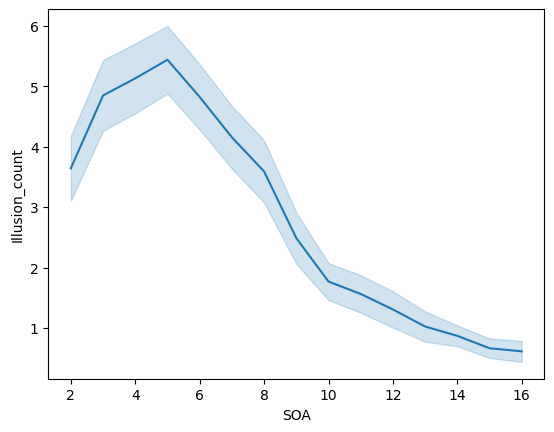

In [396]:
sns.lineplot(x="SOA", y="Illusion_count", data=data_dfi, errorbar="se")